<h1> Interactive Demo Notebook</h1>

Notebook for visualising models interactively on the given datasets. 
    After running a cell, use a cursor to interact with the image.
    One can translate the image around or orbit it. 

Run either the rotation or translation separately. Note that we've only tested this for our synsin models, not the baselines.

Note that only the most recently run cell is interactive (so if you run all cells, only the rotation example will be interactive).

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
import ipywidgets as wdg
import quaternion

from PIL import Image

In [2]:
import os
os.chdir("..")
os.environ['DEBUG'] = '0'

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from models.networks.sync_batchnorm import convert_model
from models.base_model import BaseModel

from options.options import get_model, get_dataset

<h2> Set up the models </h2>

In [3]:
torch.backends.cudnn.enabled = True

# REALESTATE
MODEL_PATH = './modelcheckpoints/realestate/zbufferpts.pth'

#MP3D
# MODEL_PATH = './modelcheckpoints/mp3d/zbufferpts.pth'

BATCH_SIZE = 1

# Set to true if you want to use a pre saved image as opposed to samples
# from the test of the dataset used to train the model
USE_IMAGE = True

In [4]:
opts = torch.load(MODEL_PATH)['opts']
opts.render_ids = [1]

model = get_model(opts)

torch_devices = [int(gpu_id.strip()) for gpu_id in opts.gpu_ids.split(",")]
print(torch_devices)
device = 'cuda:' + str(torch_devices[0])

if 'sync' in opts.norm_G:
    model = convert_model(model)
    model = nn.DataParallel(model, torch_devices[0:1]).cuda()
else:
    model = nn.DataParallel(model, torch_devices[0:1]).cuda()


#  Load the original model to be tested
model_to_test = BaseModel(model, opts)
model_to_test.load_state_dict(torch.load(MODEL_PATH)['state_dict'])
model_to_test.eval()

print("Loaded model")

Loading model %s ... 
RESNET encoder
RESNET decoder
['1.0_l1', '10.0_content']
[0, 1, 2]
Loaded model


<h2> Load the dataset </h2>

In [7]:
if USE_IMAGE:
    # Load the image
    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    im = Image.open('./demos/Crab_Nebula.jpg')
    im = transform(im)
    
    batch = {
        'images' : [im.unsqueeze(0)],
        'cameras' : [{
            'K' : torch.eye(4).unsqueeze(0),
            'Kinv' : torch.eye(4).unsqueeze(0)}]}
else:
    DatasetTrain = get_dataset(opts)

    data = DatasetTrain('test', opts, vectorize=False)
    dataloader = DataLoader(data, shuffle=False, drop_last=False, 
                            batch_size=1, num_workers=0, pin_memory=True)

    iter_dataloader = iter(dataloader)

    for i in range(0, 10):
        batch = next(iter_dataloader)


with torch.no_grad():
    pred_imgs = model_to_test.model.module.forward_angle(batch, [torch.eye(4).unsqueeze(0).repeat(1,1,1)])

Max dist:  tensor(0.0010, device='cuda:0') 0.0009765625
Max dist:  tensor(1.0000, device='cuda:0')


/root/miniconda/envs/pytorch3d/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


<h2> Run the translation example </h2>

<IPython.core.display.Javascript object>


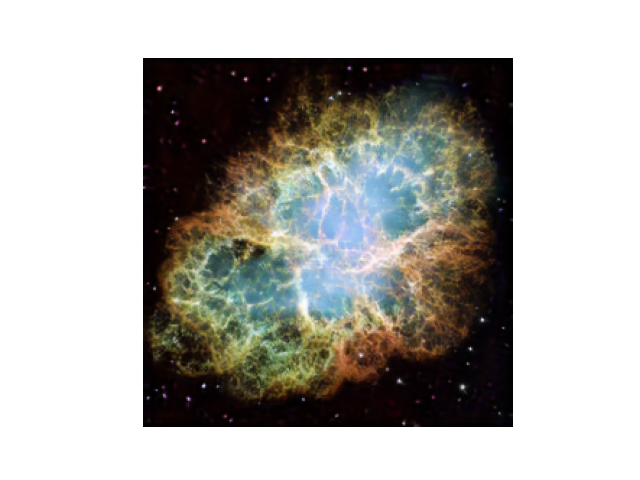

Textarea(value='', description='event:', placeholder='')

In [8]:
fig = plt.figure()

plt.axis('off')

# Create and display textarea widget
txt = wdg.Textarea(
    value='',
    placeholder='',
    description='event:',
    disabled=False
)
display(txt)

pred_imshow = plt.imshow(pred_imgs[0].squeeze().cpu().permute(1,2,0).numpy() * 0.5 + 0.5)

import time

class MouseEvent:
    def __init__(self):
        self.x = 0
        self.y = 0
        
        self.clicked = False
        
        self.prev_time = 0
        
    def onclick(self, event):
        self.clicked = True

    def onmotion(self, event):
        if not(self.clicked):
            return
        
        delta_time = time.time() - self.prev_time 
        
        if delta_time < 0.25:
            return
        
        txt.value = 'Delta time'
        
        self.prev_time = time.time()
        
        rel_value = '(%0.4f,%0.4f) released' % (event.xdata, event.ydata)
        dx = (event.xdata - 128.) / 256.
        dy = (event.ydata - 128.) / 256.
    
        # Visualise the scene at the new position
        RTs = torch.eye(4)
        RTs[0,3] = dx
        RTs[1,3] = dy
        
        txt.value = "(%0.4f, %0.4f) :: (%0.4f, %0.4f)" % (event.xdata, event.ydata, dx, dy)
        
        
        with torch.no_grad():
            pred_imgs = model_to_test.model.module.forward_angle(batch, [RTs.unsqueeze(0)])
        pred_imshow.set_data(pred_imgs[0].squeeze().cpu().permute(1,2,0).numpy() * 0.5 + 0.5)
        plt.draw()
        
    def onrelease(self, event):
        self.clicked = False
        RTs = torch.eye(4)
        
        with torch.no_grad():
            pred_imgs = model_to_test.model.module.forward_angle(batch, [RTs.unsqueeze(0)])
        pred_imshow.set_data(pred_imgs[0].squeeze().cpu().permute(1,2,0).numpy() * 0.5 + 0.5)
        plt.draw()
        
        
    

event_tracker = MouseEvent()

# Create an hard reference to the callback not to be cleared by the garbage collector
bp = fig.canvas.mpl_connect('button_press_event', event_tracker.onclick)
br = fig.canvas.mpl_connect('button_release_event', event_tracker.onrelease)
br = fig.canvas.mpl_connect('motion_notify_event', event_tracker.onmotion)

<h2>Run the rotation example </h2>

<IPython.core.display.Javascript object>


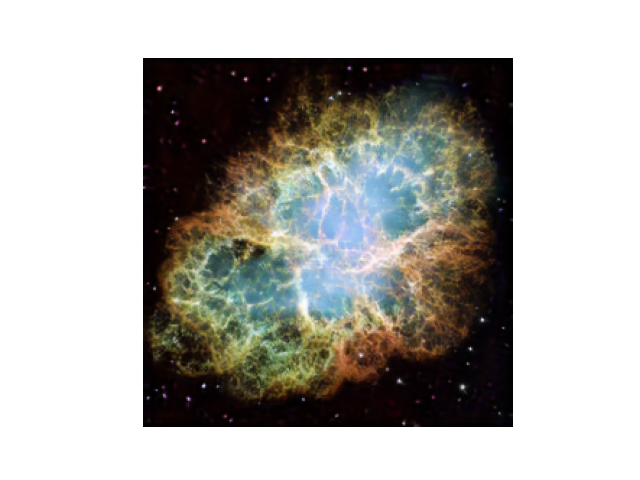

Textarea(value='', description='event:', placeholder='')

In [9]:
fig = plt.figure()

plt.axis('off')

# Create and display textarea widget
txt = wdg.Textarea(
    value='',
    placeholder='',
    description='event:',
    disabled=False
)
display(txt)

pred_imshow = plt.imshow(pred_imgs[0].squeeze().cpu().permute(1,2,0).numpy() * 0.5 + 0.5)

import time

class MouseEvent:
    def __init__(self):
        self.x = 0
        self.y = 0
        
        self.clicked = False
        
        self.prev_time = 0
        
    def onclick(self, event):
        self.clicked = True
        txt.value='Clicked'

    def onmotion(self, event):
        if not(self.clicked):
            return
        
        delta_time = time.time() - self.prev_time 
        
        if delta_time < 0.25:
            return
        
        
        self.prev_time = time.time()
        
        dx = (event.xdata - 128.) * 0.001
        dy = (event.ydata - 128.) * 0.00005
        
        
        flip_y = dy < 0
        dy = 1 - dy
        
        theta = np.arcsin(dx)
        
        if flip_y:
            phi = - np.arccos(1 + (1 - dy))
        else:
            phi = np.arccos(dy)
            
        # Visualise the scene at the new position
        RTs = torch.eye(4)
        
        RTs[0:3,0:3] = torch.Tensor(quaternion.as_rotation_matrix(quaternion.from_rotation_vector([phi, theta, 0])))

        with torch.no_grad():
            pred_imgs = model_to_test.model.module.forward_angle(batch, [RTs.unsqueeze(0)])
        pred_imshow.set_data(pred_imgs[0].squeeze().cpu().permute(1,2,0).numpy() * 0.5 + 0.5)
        plt.draw()
        
    def onrelease(self, event):
        self.clicked = False
        txt.value='Release clicked'
        RTs = torch.eye(4)
        
        with torch.no_grad():
            pred_imgs = model_to_test.model.module.forward_angle(batch, [RTs.unsqueeze(0)])
        pred_imshow.set_data(pred_imgs[0].squeeze().cpu().permute(1,2,0).numpy() * 0.5 + 0.5)
        plt.draw()
        
        
    

event_trackerRotate = MouseEvent()

# Create an hard reference to the callback not to be cleared by the garbage collector
bp = fig.canvas.mpl_connect('button_press_event', event_trackerRotate.onclick)
br = fig.canvas.mpl_connect('button_release_event', event_trackerRotate.onrelease)
br = fig.canvas.mpl_connect('motion_notify_event', event_trackerRotate.onmotion)